# Occupancy Distribution Through Time.

Let's gain some insights about the distribution of occupancy count across time and locations.

We'll start by setting up the script.

In [2]:
# The Python interpreter requires this workaround to
# import modules outside of this notebook's directory.
import sys
sys.path.append("..")

In [3]:
# Third-party and standard modules
from typing import Optional
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import pytz
from importlib import reload

# User-defined modules.
# The reload() function is needed to update modules after
# changes are made to their files.
import dataframe_manip as dfm
dfm = reload(dfm)

In [4]:
def dataframe_info(d: pd.DataFrame) -> str:
    """A basic function for getting dataframe info."""
    return """
    shape: {}
    index datatype: {}
    na value count: {}
    """.format(
        str(d.shape),
        d.index.dtype,
        d.isna().sum().sum()
    )

## The main dataframe: `occupancy`

We'll be mainly working with a single dataframe named `occupancy` created from the csv provided.

`occupancy` is a time-series dataframe. Each of its rows represents a point in time. Each of its columns represents a WiFi access point.

In [5]:
filepath = './wifi_data_until_20190204.csv'
timezone = pytz.timezone('US/Pacific')

occupancy: pd.DataFrame = dfm.csv_to_timeseries_df(
    filepath=filepath, timezone=timezone
)

print(dataframe_info(occupancy))
print(occupancy)


    shape: (57772, 612)
    index datatype: datetime64[ns, US/Pacific]
    na value count: 23958512
    
                           POM-SUMNER212-AP205-2  POM-SMITH-AP275-4  \
time                                                                  
2018-07-18 16:10:14-07:00                    5.0                NaN   
2018-07-18 16:15:23-07:00                    5.0                NaN   
2018-07-18 16:20:38-07:00                    5.0                NaN   
2018-07-18 16:25:06-07:00                    7.0                NaN   
2018-07-18 16:30:06-07:00                    8.0                NaN   
2018-07-18 16:35:08-07:00                    3.0                NaN   
2018-07-18 16:40:12-07:00                    2.0                NaN   
2018-07-18 16:45:16-07:00                    1.0                NaN   
2018-07-18 16:50:19-07:00                    1.0                NaN   
2018-07-18 16:55:12-07:00                    1.0                NaN   
2018-07-18 17:00:07-07:00                 

## Occupancy by the hour

Let's start by finding out how total connectivity (across all access points) varies by the hour.

We'll reduce `data` to the `total_occupancy_vs_time` dataframe. Like `data`, each of its rows represents a point in time. However, it only has one column representing all access points.

In [6]:
total_occupancy_vs_time = dfm.row_totals(occupancy)

print(dataframe_info(
    total_occupancy_vs_time
))


    shape: (57772,)
    index datatype: datetime64[ns, US/Pacific]
    na value count: 0
    


Let's create create 24 boxplots --each representing 1 hour-- which show how the distribution of **occupancy** (as measured by the number of devices connected to access points) *throughout all buildings* varies hour-by-hour.

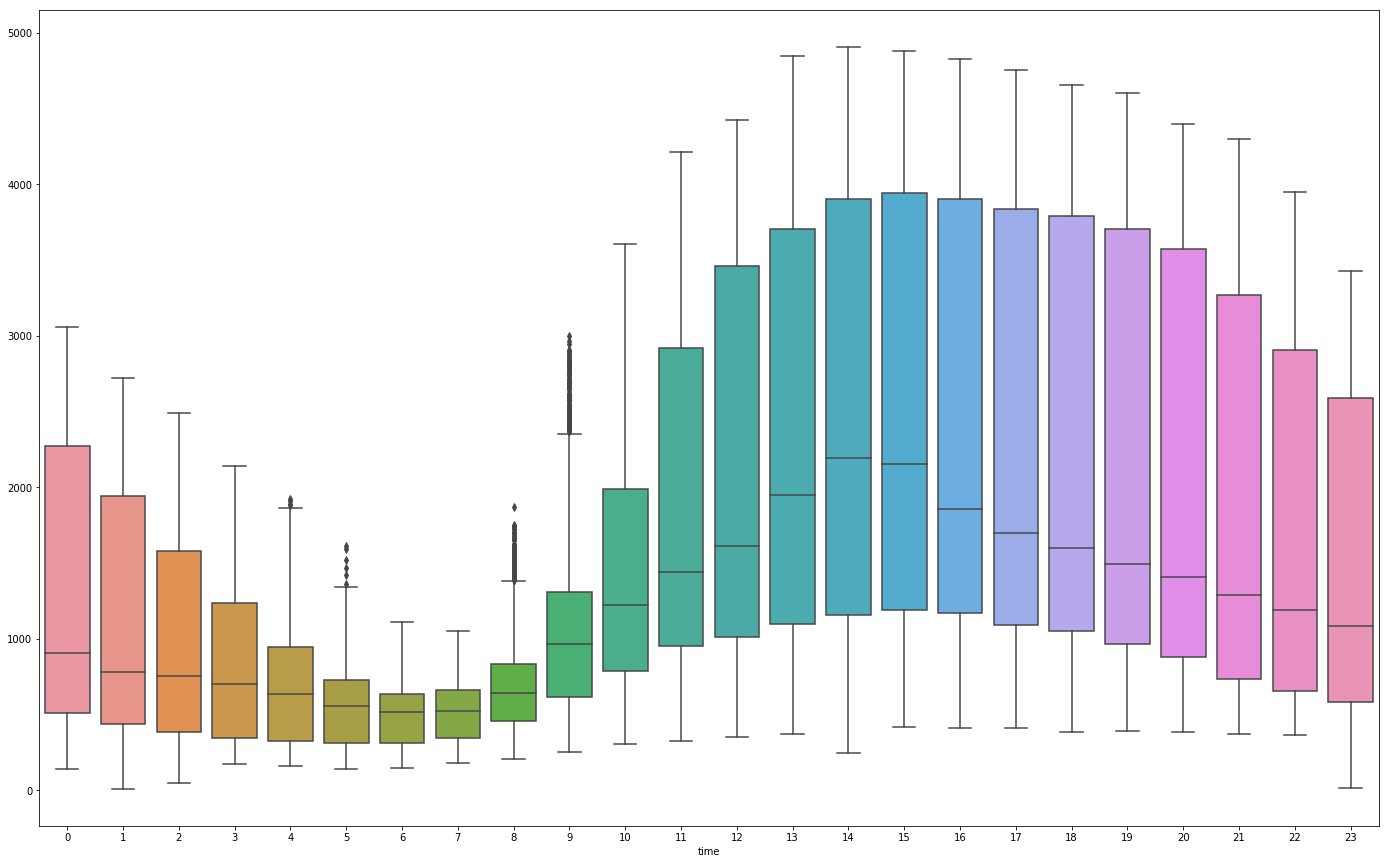

In [7]:
fig, ax = plt.subplots(figsize=(24, 15))

seaborn.boxplot(
    # The hours (a number [0,23]) for each row.
    x=total_occupancy_vs_time.index.hour,
    # The total occupancy at that hour.
    y=total_occupancy_vs_time,
    ax=ax
)

It's immediately clear that measures of occupancy total have strong relationships with the hour of the day. The transitions between hours are smooth (i.e. continuous) and aggressive.

The total **peaks around 14:30 (2:30 pm)** and is **lowest around 6:30**.

Interestingly, the **interquartile range** (i.e. rectangle length) in occupancy also **peaks around 2:30** and is **lowest around 6:30**. The upper quartile (75th percentile) moves far more aggressively than the lower quartile or median. This may be due to a fixed/stable number of devices which don't vary much throughout the day. These could be public devices (e.g. library computers) or staff devices (e.g. staff phones). It's worth noting that the minimum doesn't change much throughout the day.

In [8]:
# acpt is short for 'access point'
stats_per_acpt: pd.DataFrame = pd.DataFrame.from_dict({
    'total':
    dfm.column_totals(occupancy),
    'mean':
    dfm.column_means(occupancy, skipna=True),
    'mean, skipna=False':
    dfm.column_means(occupancy, skipna=False),
    'median':
    dfm.column_medians(occupancy, skipna=True),
    'median, skipna=False':
    dfm.column_medians(occupancy, skipna=False)
})

print(dataframe_info(
    stats_per_acpt
))


    shape: (612, 5)
    index datatype: object
    na value count: 1224
    
